# Two Intervals Around the Current Price
This strategy aims to fix the problem of having leftover liquidity. The first interval is the same as in the interval around the current price strategy 4.4, namely [pc − a, pc + a]. Let b be a paramter and b ∈ [10, 1000], then the second interval will either be [pc, pc +b] or [pc −b, pc], depending on which asset is leftover [4]. This will allow us to use up all our liquidity.

Import code dependencies

In [1]:
from typing import List

import pandas as pd
from matplotlib.pylab import plt
import matplotlib.dates as mdates

from demeter import MarketInfo
from demeter.broker import AccountStatus

Set matplotlib to show formatted account status

In [2]:
def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()

Make plot about price and account value / position net value

In [3]:
def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name + "_net_value"]
    value_in_account = account_status["USDC"] + account_status["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()

Add dependence about run Actuator

In [4]:
from datetime import timedelta, date
from typing import Dict
from _decimal import Decimal
import pandas as pd

from demeter import TokenInfo, Actuator, ChainType, MarketInfo, Strategy, PeriodTrigger, EvaluatorEnum, RowData
from demeter.uniswap import UniV3Pool, UniLpMarket

Set pandas output format

In [5]:
pd.options.display.max_columns = None
pd.set_option("display.width", 5000)

Custom Two Intervals Around the Current Price strategy with code to add liquidity at constant interval around current price.

In [6]:
class TwoIntervalsAroundtheCurrentPriceStrategy(Strategy):
    def __init__(self, a=10, b=1, update_interval=timedelta(days=1)):
        super().__init__()
        self.a = a
        self.b = b

    def initialize(self):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        init_price = lp_market.market_status.data.price

        lp_market.add_liquidity(init_price - self.a, init_price + self.a)
        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(init_price - self.b, init_price)
        else:
            lp_market.add_liquidity(init_price, init_price + self.b)
        self.triggers.append(PeriodTrigger(time_delta=timedelta(days=1), do=self.work))

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]

        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])

        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(row_data.prices[eth.name] - self.b, row_data.prices[eth.name])
        else:
            lp_market.add_liquidity(row_data.prices[eth.name], row_data.prices[eth.name] + row_data.prices[eth.name] + self.b)


Main logic to run Actuator, init two token and market with key "market1"

In [7]:
usdc = TokenInfo(name="usdc", decimal=6)  # declare  token0
eth = TokenInfo(name="eth", decimal=18)  # declare token1
pool = UniV3Pool(usdc, eth, 0.05, usdc)  # declare pool
market_key = MarketInfo("market1")

actuator = Actuator()  # declare actuator
broker = actuator.broker
market = UniLpMarket(market_key, pool)

broker.add_market(market)
broker.set_balance(usdc, 2000)
broker.set_balance(eth, 0)

actuator.strategy = TwoIntervalsAroundtheCurrentPriceStrategy(400, 200)

market.data_path = "../data"
market.load_data(ChainType.polygon.name, "0x45dda9cb7c25131df268515131f647d726f50608", date(2023, 8, 13), date(2023, 8, 17))
actuator.set_price(market.get_price_from_data())
# actuator.run()  # run test

2023-11-03 10:14:54,782 - INFO - start load files from 2023-08-13 to 2023-08-17...
2023-11-03 10:14:54,849 - INFO - load file complete, preparing...
2023-11-03 10:14:55,167 - INFO - data has been prepared


Run actuator with evaluators and save result to files

In [8]:
actuator.run(evaluator=[
        EvaluatorEnum.max_draw_down,
        EvaluatorEnum.annualized_returns,
        EvaluatorEnum.net_value,
        EvaluatorEnum.profit,
        EvaluatorEnum.net_value_up_down_rate,
        EvaluatorEnum.eth_up_down_rate,
        EvaluatorEnum.position_fee_profit,
        EvaluatorEnum.position_fee_annualized_returns,
        EvaluatorEnum.position_market_time_rate,
    ])
evaluating_result: Dict[EvaluatorEnum, Decimal] = actuator.evaluating_indicator

actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)

2023-11-03 10:14:55,183 - INFO - init strategy...
2023-11-03 10:14:55,187 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7200/7200 [00:04<00:00, 1539.07it/s]
2023-11-03 10:14:59,893 - INFO - main loop finished
2023-11-03 10:14:59,945 - INFO - Start calculate evaluating indicator...
/Users/florije/PycharmProjects/demeter/demeter/core/evaluating_indicator.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fee_df.sort_values(by=["market1_base_uncollected", "market1_quote_uncollected"], ascending=[False, False], inplace=True)
2023-11-03 10:15:00,015 - INFO - Evaluating indicator has finished it's job.
2023-11-03 10:15:00,016 - INFO - Print actuator summary
2023-11-03 10:15:00,029 - INFO - Backtesting finished, 

Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.5484461981970613597932912391
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee       :0.0500                   is 0 base :True                     
positions 
   lower_tick  upper_tick                       pending0                          pending1        liquidity
0      201328      202501  3.189328974092320055545237895  0.002059715427735790766147000412  409238750694668

Account balance history                           
                                         net_value USDC                             ETH              market1_net_value       market1_base_uncollected         market1_quote_uncollected       market1_base_in_position       market1_quote_in_position  market1_position_count
2023-08-13 00:00:00  2000.000344535910899686023786    0                               0  2000

['./result/backtest-20231103-101500.account.csv',
 './result/backtest-20231103-101500.action.json',
 './result/backtest-20231103-101500.action.pkl']

Make plot about output net value、value in position、value in account and price

/var/folders/n6/c_55zk7d3nqb3jhk31yv_60r0000gn/T/ipykernel_95242/822488339.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


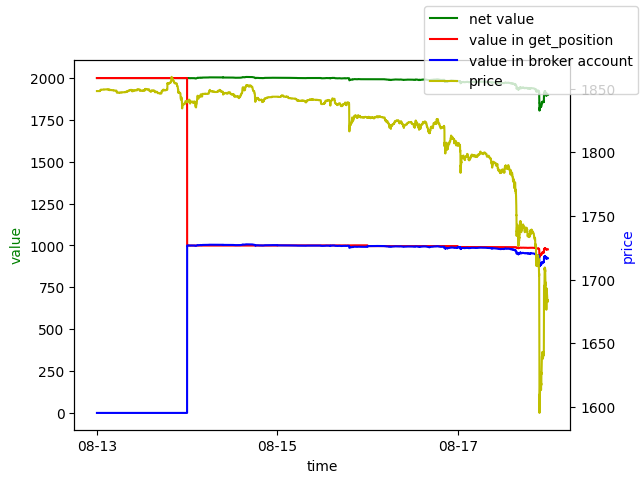

In [9]:
plot_position_return_decomposition(actuator.get_account_status_dataframe(), actuator.token_prices[eth.name], market_key)